<a href="https://colab.research.google.com/github/hnm15/DS703/blob/main/Homework_07_mod_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 7: Sentiment Classification with Pre-trained and Re-trained GloVe Embeddings

## Due: Midnight on October 19th @ Midnight (with 2-hour grace period) and worth 85 points.

In this notebook, we’ll continue with the investigation of text classification using "Bag of Embeddings" models and the IMDB movie review dataset.
We'll focus on unfrozen embeddings, which refine the embedding space based on your dataset.

You'll do three problems:

* **Problem One:** Build a baseline model with unfrozen embeddings and experiment with architectural and training adjustments to improve performance.
* **Problem Two:** Investigate how increasing the maximum message length and vocabulary size affects model accuracy and generalization.
* **Problem Three:** Examine the impact of changing the embedding dimension on model performance.


In each problem, you'll report your best validation accuracy and reflect on what you have learned.

### Useful Imports

In [49]:
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from collections import Counter


from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Sequential
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.layers import LayerNormalization, MaxPooling2D,Dropout,GlobalAveragePooling2D,Dense
from tensorflow.keras.layers import Conv2D,BatchNormalization,Activation,GlobalMaxPooling1D, Flatten
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.model_selection import StratifiedShuffleSplit


# Reproducibility

random_seed = 42

np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# utility code

from datetime import datetime

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

'''  How to time your code
# start timer
start_time = time.time()

<your code here>

# Record end time and print execution time
print(f"Execution Time: " + format_time(time.time()-start_time))
'''

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

### Utility function to plot learning curves and keep track of all results

- Call `print_results()` to see listing of all results logged so far
- We've also added  `

In [50]:
def plot_learning_curves(hist, title, verbose=True):

    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()


###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- Uses "binary_crossentropy" for binary classification task.
- Assumes `X_train,y_train,X_test,y_test` already defined, will access them as global variables.
- If `X_val` and `y_val` defined, will use those, else assumes `validation_split = 0.2` in `fit`


**Note:** See the end of the notebook for results and parameter settings.

In [51]:
def train_and_test(model,
                   title         = "Learning Curves",
                   epochs        = 200,                   # Just needs to be bigger than early stopping point
                   optimizer     = "Adam",
                   lr_schedule   = 1e-3,                  # Adam defaults
                   clipnorm      = None,
                   batch_size    = 128,
                   loss          = "binary_crossentropy",
                   metrics       = ["accuracy"],
                   use_early_stopping = True,
                   patience      = 10,
                   min_delta     = 0.0001,
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")

    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule,clipnorm=clipnorm)
    else:
        opt = optimizer

    #Compiling the model
    model.compile(optimizer = opt,
                  loss      = loss,
                  metrics   = metrics
                 )



    if use_early_stopping:
        early_stop = EarlyStopping(
            monitor              = 'val_loss',
            patience             = patience,
            min_delta            = min_delta,
            restore_best_weights = True,               # this will mean that the model which produced the smallest validation loss will be returned
            verbose              = verbose
        )
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()

    # Fit the model with early stopping
    # If X_val defined, then  use it, else assume val is split from train

    if 'X_val' in globals():
        history = model.fit(X_train, y_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(X_val, y_val),
                            callbacks=cbs,
                            verbose=verbose
                           )
    else:
        history = model.fit(X_train, y_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_split=0.2,
                            callbacks=cbs,
                            verbose=verbose
                           )

    # Plot training history
    plot_learning_curves(history, title=title)

    # Find epoch with minimum validation loss
    min_val_epoch = np.argmin(history.history['val_loss'])
    # Retrieve the values at that epoch
    min_val_loss = history.history['val_loss'][min_val_epoch]
    # Get corresponding validation accuracy at that epoch
    val_acc_at_min_loss = history.history['val_accuracy'][min_val_epoch]

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    # Print out results

    print(f"\nFinal Training Loss:            {history.history['loss'][-1]:.4f}")
    print(f"Final Training Accuracy:        {history.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Loss:          {history.history['val_loss'][-1]:.4f}")
    print(f"Final Validation Accuracy:      {history.history['val_accuracy'][-1]:.4f}")
    print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
    print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Accuracy Gap: {abs(val_acc_at_min_loss - test_accuracy):.6f}")

    # Store accuracy in results
    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

    # Store all information about run in parameter_settings

    global parameter_settings
    entry = {
        "title": title,
        "timestamp": datetime.now().isoformat(timespec="seconds"),
        "epochs": int(epochs),
        "optimizer": optimizer,
        "lr_schedule": lr_schedule,
        "clipnorm": clipnorm,
        "loss": loss,
        "batch_size": batch_size,
        "use_early_stopping": use_early_stopping,
        "patience": patience,
        "min_delta": min_delta,
        "callbacks": _summarize_callbacks(callbacks),
        "Final Training Loss" : history.history['loss'][-1],
        "Final Training Accuracy" : history.history['accuracy'][-1],
        "Final Val Loss" : history.history['val_loss'][-1],
        "Final Val Accuracy" : history.history['val_accuracy'][-1],
        "Min Val Loss" : min_val_loss,
        "Min Val Loss Epoch" : min_val_epoch,
        "Val Acc @ Min Loss" : val_acc_at_min_loss,
        "Test Loss" : test_loss,
        "Test Acc" : test_accuracy,
        "Val-Test Accuracy Gap:" : abs(val_acc_at_min_loss - test_accuracy)
    }
    parameter_settings.setdefault(title, []).append(entry)

    if return_history:
        return history

def _summarize_callbacks(cbs):
    if cbs is None:
        return None
    out = []
    for cb in cbs:
        name = getattr(cb, "__class__", type(cb)).__name__
        info = {"class": name}
        # grab a few common attributes if present
        for attr in ("monitor", "mode", "patience", "min_delta",
                     "factor", "min_lr", "verbose", "cooldown"):
            if hasattr(cb, attr):
                info[attr] = getattr(cb, attr)
        out.append(info)
    return out

results = {}
parameter_settings = {}

def print_results():
    for title, (acc, ep) in sorted(results.items(),
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}\t{ep}")

In [52]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=5,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-5,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-8,           # Lower bound on the learning rate.
    verbose=1,             # 0: quiet, 1: update messages.
)

#  put in the callbacks list:

#    train_and_test(model, title="Learning Curves",callbacks=[reduce_lr])


### Prelude:  A little EDA: Distribution of review lengths and coverage by max vocabulary size

You will use this to think about where the set parameters for maximum review length and the maximum number of unique tokens to use.


Total unique words in Keras IMDB word_index (corpus-wide): 88,584
Num training reviews: 25,000
Max length: 2,494 tokens
Mean length: 238.7 tokens
Median length: 178 tokens
90th percentile: 467 tokens
95th percentile: 610 tokens
99th percentile: 926 tokens


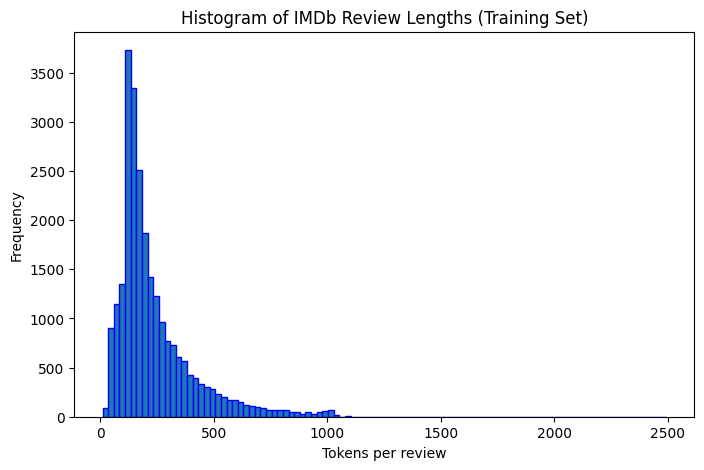


Unique word types in TRAIN (id >= 3): 88,583
Total word tokens in TRAIN (id >= 3): 5,942,840

Coverage metrics by candidate vocab size (TRAIN split):
training_vocabulary_size= 2,000 | coverage= 82.84% | OOV= 17.16% | types kept=  1,997 | tokens kept= 4,922,766
training_vocabulary_size= 5,000 | coverage= 90.03% | OOV=  9.97% | types kept=  4,997 | tokens kept= 5,350,551
training_vocabulary_size=10,000 | coverage= 94.25% | OOV=  5.75% | types kept=  9,997 | tokens kept= 5,601,261
training_vocabulary_size=20,000 | coverage= 97.22% | OOV=  2.78% | types kept= 19,997 | tokens kept= 5,777,376
training_vocabulary_size=30,000 | coverage= 98.37% | OOV=  1.63% | types kept= 29,997 | tokens kept= 5,846,141
training_vocabulary_size=50,000 | coverage= 99.32% | OOV=  0.68% | types kept= 49,997 | tokens kept= 5,902,246
training_vocabulary_size=70,000 | coverage= 99.69% | OOV=  0.31% | types kept= 69,997 | tokens kept= 5,924,254
training_vocabulary_size=88,584 | coverage=100.00% | OOV=  0.00% | types

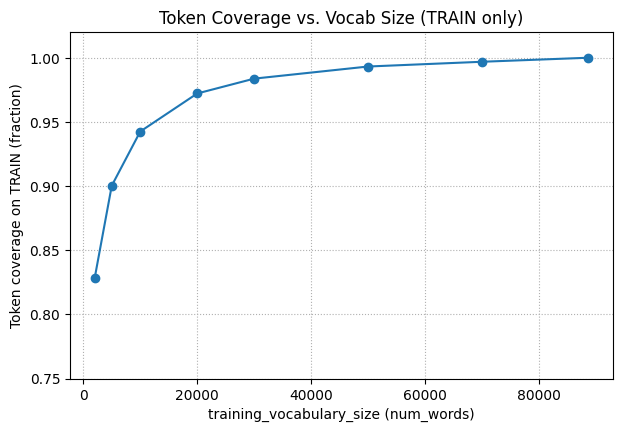

In [53]:
# IMDB vocab & length stats + coverage table + single coverage plot

from tensorflow.keras.datasets import imdb
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------
# Load IMDB with NO cap (so we can measure coverage fairly)
# ---------------------------------------
(X_tr, y_tr), _ = imdb.load_data()

# ---------------------------------------
# 1) Global vocab stats (from Keras word_index)
# ---------------------------------------
word_index = imdb.get_word_index()  # mapping: word -> rank (lower rank = more frequent)
total_unique_words_corpus = len(word_index)  # across the full IMDB corpus Keras ships
print(f"Total unique words in Keras IMDB word_index (corpus-wide): {total_unique_words_corpus:,}")

# ---------------------------------------
# 2) Training review length stats + histogram (students pick max_text_length)
# ---------------------------------------
lengths = np.fromiter((len(r) for r in X_tr), dtype=np.int32)
print(f"Num training reviews: {len(lengths):,}")
print(f"Max length: {lengths.max():,} tokens")
print(f"Mean length: {lengths.mean():.1f} tokens")
print(f"Median length: {np.median(lengths):.0f} tokens")
for q in (90, 95, 99):
    print(f"{q}th percentile: {int(np.percentile(lengths, q))} tokens")

plt.figure(figsize=(8, 5))
plt.hist(lengths, bins=100, edgecolor='b')
plt.title("Histogram of IMDb Review Lengths (Training Set)")
plt.xlabel("Tokens per review")
plt.ylabel("Frequency")
plt.show()

# ---------------------------------------
# 3) Training-only frequency counts for real words (ids >= 3)
#    IMDB ID conventions: 0=<PAD>, 1=<START>, 2=<OOV>, >=3 actual words
# ---------------------------------------
def iter_tokens(seqs):
    for s in seqs:
        for t in s:
            yield t

train_counts = Counter(t for t in iter_tokens(X_tr) if t >= 3)

# Frequency list (descending) and cumulative token coverage
freqs = np.array(sorted(train_counts.values(), reverse=True), dtype=np.int64)
cum_tokens = np.cumsum(freqs)
total_tokens_train_words = int(cum_tokens[-1])
num_unique_words_train = int(len(freqs))

print(f"\nUnique word types in TRAIN (id >= 3): {num_unique_words_train:,}")
print(f"Total word tokens in TRAIN (id >= 3): {total_tokens_train_words:,}")

# ---------------------------------------
# 4) Coverage helper for a given num_words cap (Keras convention)
#    Valid word ids are [3, num_words_cap-1] → ranks [1 .. num_words_cap-3]
# ---------------------------------------
def coverage_for_cap(num_words_cap: int):
    kept_types = max(0, min(num_words_cap - 3, num_unique_words_train))
    kept_tokens = int(cum_tokens[kept_types - 1]) if kept_types > 0 else 0
    oov_tokens = total_tokens_train_words - kept_tokens
    coverage = kept_tokens / total_tokens_train_words if total_tokens_train_words > 0 else 0.0
    oov_share = oov_tokens / total_tokens_train_words if total_tokens_train_words > 0 else 0.0
    return dict(
        cap=num_words_cap,
        kept_tokens=kept_tokens,
        kept_types=kept_types,
        coverage=coverage,
        oov_share=oov_share
    )

# ---------------------------------------
# 5) Candidate vocab sizes: ASCII table + single coverage plot
# ---------------------------------------
candidate_caps = [2_000, 5_000, 10_000, 20_000, 30_000, 50_000,70_000,88_584]  # students can edit
rows = [coverage_for_cap(k) for k in candidate_caps]

print("\nCoverage metrics by candidate vocab size (TRAIN split):")
for r in rows:
    print(f"training_vocabulary_size={r['cap']:>6,} | coverage={r['coverage']*100:6.2f}% | "
          f"OOV={r['oov_share']*100:6.2f}% | types kept={r['kept_types']:>7,} | tokens kept={r['kept_tokens']:>10,}")

plt.figure(figsize=(7, 4.5))
plt.plot(candidate_caps, [r['coverage'] for r in rows], marker='o')
plt.xlabel("training_vocabulary_size (num_words)")
plt.ylabel("Token coverage on TRAIN (fraction)")
plt.title("Token Coverage vs. Vocab Size (TRAIN only)")
plt.grid(True, linestyle=":")
plt.ylim(0.75, 1.02)
plt.show()


### Load and preprocess dataset

Here is where you can set the
- `training_vocabulary_size` and
- `max_text_length`

In [54]:
# Load and preprocess dataset into padded sequences of token IDs

training_vocabulary_size = 50_000               # <-----
max_text_length          = 500                  # <-----

(X_tr, y_tr), (X_te, y_te) = imdb.load_data( num_words = training_vocabulary_size )

X  = np.concatenate([X_tr, X_te], axis=0)
y  = np.concatenate([y_tr, y_te], axis=0)

# 80 / 20 stratified split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=random_seed,
    stratify=y
)



X_train = pad_sequences(
    X_train,
    maxlen=max_text_length,
    padding='post',
    truncating='post'
)

X_test = pad_sequences(
    X_test,
    maxlen=max_text_length,
    padding='post',
    truncating='post'
)


X_train.shape,X_test.shape

((40000, 500), (10000, 500))

### Build the embedding matrix

Here is where you can set
- `embedding_dimension`


In [55]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip -d glove.6B


--2025-10-16 01:02:16--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-10-16 01:02:16--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-10-16 01:02:17--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [56]:
from pathlib import Path

glove_path = Path("glove.6B/glove.6B.100d.txt")
print(glove_path.exists())


True


In [57]:
#  Build embedding matrix


embedding_dimension = 100                     # <-----

word_index      = imdb.get_word_index()

glove_path = Path(f"glove.6B/glove.6B.{embedding_dimension}d.txt")

embeddings_index = {}
with glove_path.open(encoding='utf8') as f:
    for line in f:
        word, *vec = line.split()
        embeddings_index[word] = np.asarray(vec, dtype='float32')


# Build embedding matrix

embedding_matrix = np.zeros((training_vocabulary_size, embedding_dimension))

for word, raw_idx in word_index.items():
    idx = raw_idx + 3                            # shift by 3 to match Keras’s token IDs
    if idx < training_vocabulary_size:
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[idx] = vec


### Baseline Model from the Coding Notebook


model_baseline (frozen)



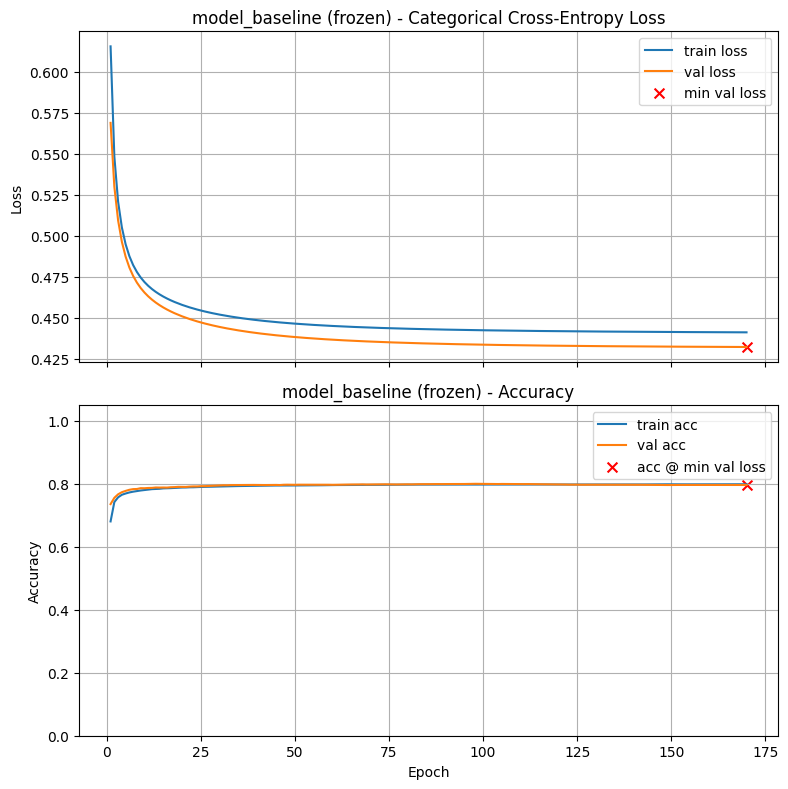


Execution Time: 00:01:47

Final Training Loss:            0.4411
Final Training Accuracy:        0.7985
Final Validation Loss:          0.4321
Final Validation Accuracy:      0.7961
Minimum Validation Loss:        0.4321 (Epoch 170)
Validation Accuracy @ Min Loss: 0.7961

Test Loss: 0.4331
Test Accuracy: 0.8076

Validation-Test Accuracy Gap: 0.011475


In [58]:

model_baseline_frozen = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),   # each sample is a sequence of max_text_length integers, e.g., 500
    Embedding(
        input_dim  = training_vocabulary_size,
        output_dim = embedding_dimension,
        weights    = [embedding_matrix],
        mask_zero  = True,                      # ignore <PAD> in pooling -- this makes a huge difference in training speed!
        trainable  = False                      # freeze or unfreeze embedding weights
    ),
    GlobalAveragePooling1D(),                        # take average along each dimension
    Dense(1, activation='sigmoid')
])


train_and_test(model_baseline_frozen,  lr_schedule=1e-2, title="model_baseline (frozen)")

#### End of Template Code from Coding Notebook

## Problem One: Baseline with Unfrozen Embeddings

**ToDo:**

1. Establish a baseline for unfrozen embeddings by running the baseline model but with `trainable = True` to retrain the embeddings as it trains on the the classification task. You will use retrainable embeddings throughout the homework.

2. Now run 2-3 experiments to try to improve this baseline:

    - Consider adding a Dense layer between the global average pooling and the output layer, with
        - Your choice of size
        - Your choice of L2 regularizatio (or not)
        - Your choice of dropout (or not)
3. As needed, tweak the learning rate (try `1e-4`) and try it with or without Reduce on Plateau (you can tweak the parameters there as well)
4. Define your best model for unfrozen embeddings based on these experiments (you will use it in the remaining two problems)
5. Answer the graded questions

**Note:** Generally, you will need a lower learning rate for retrainable embeddings.


model_baseline_unfrozen (lr=1e-3)



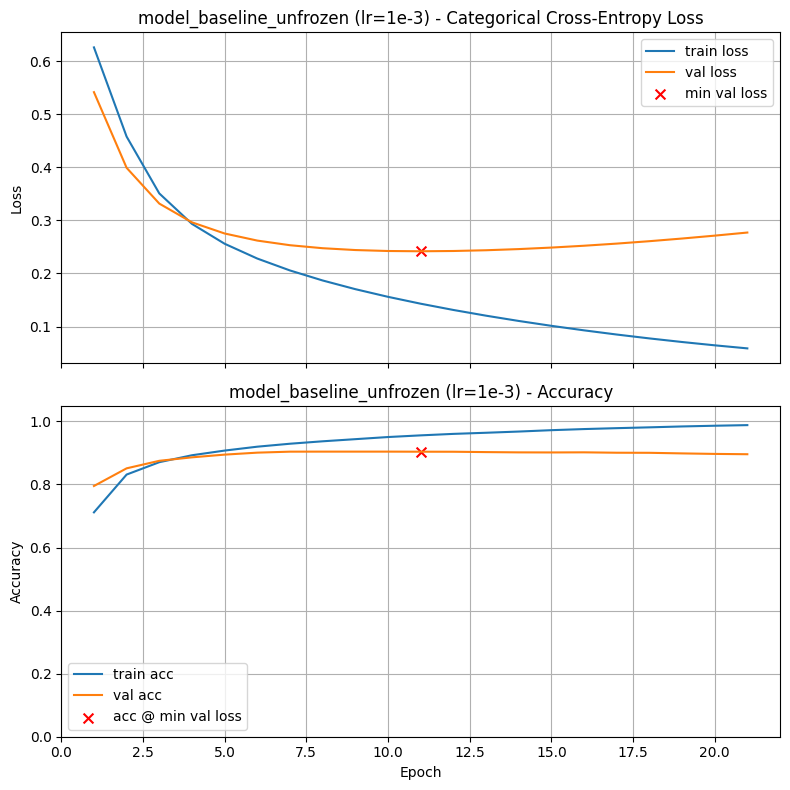


Execution Time: 00:00:21

Final Training Loss:            0.0589
Final Training Accuracy:        0.9882
Final Validation Loss:          0.2772
Final Validation Accuracy:      0.8959
Minimum Validation Loss:        0.2419 (Epoch 11)
Validation Accuracy @ Min Loss: 0.9039

Test Loss: 0.2544
Test Accuracy: 0.8994

Validation-Test Accuracy Gap: 0.004475


In [59]:
# Your code here; add as many cells as you need

from tensorflow.keras import regularizers

model_baseline_unfrozen = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim  = training_vocabulary_size,
        output_dim = embedding_dimension,
        weights    = [embedding_matrix],
        mask_zero  = True,
        trainable  = True
    ),
    GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')
])

train_and_test(model_baseline_unfrozen,
               lr_schedule=1e-3,
               title="model_baseline_unfrozen (lr=1e-3)")




exp1: Dense(64)+L2(1e-4)+Dropout(0.5) (lr=1e-4)



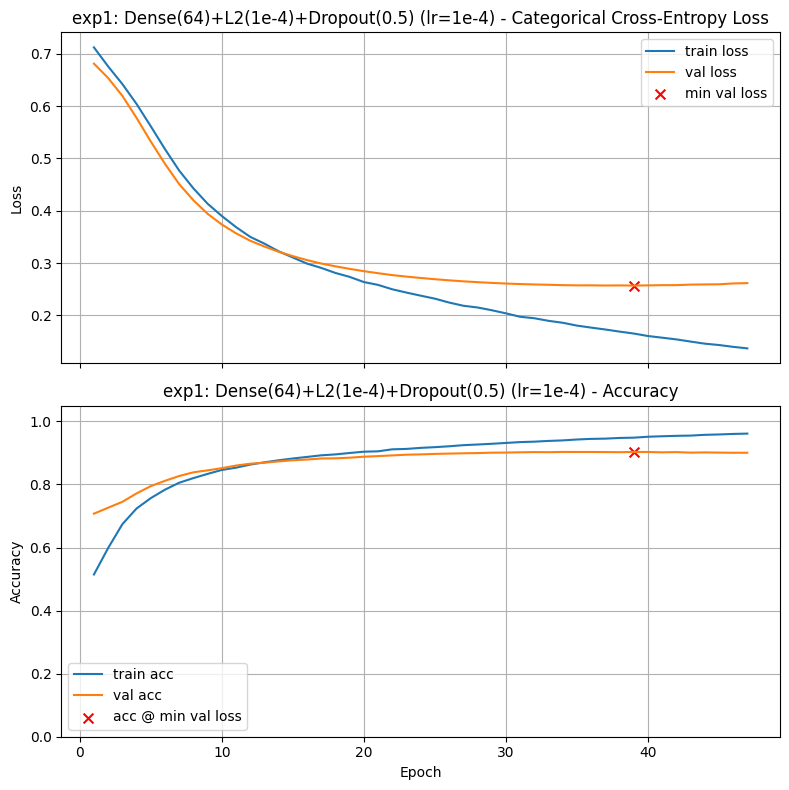


Execution Time: 00:00:47

Final Training Loss:            0.1369
Final Training Accuracy:        0.9613
Final Validation Loss:          0.2616
Final Validation Accuracy:      0.9006
Minimum Validation Loss:        0.2569 (Epoch 39)
Validation Accuracy @ Min Loss: 0.9031

Test Loss: 0.2707
Test Accuracy: 0.8983

Validation-Test Accuracy Gap: 0.004825


In [60]:
# Experiment 1: Add Dense layer with L2 regularization + Dropout

model_exp1 = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim  = training_vocabulary_size,
        output_dim = embedding_dimension,
        weights    = [embedding_matrix],
        mask_zero  = True,
        trainable  = True
    ),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

train_and_test(model_exp1,
               lr_schedule=1e-4,
               title="exp1: Dense(64)+L2(1e-4)+Dropout(0.5) (lr=1e-4)")



exp2: Dense(128)+L2(5e-5)+Dropout(0.3)+ReduceLR (lr=1e-4)


Epoch 35: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 40: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.


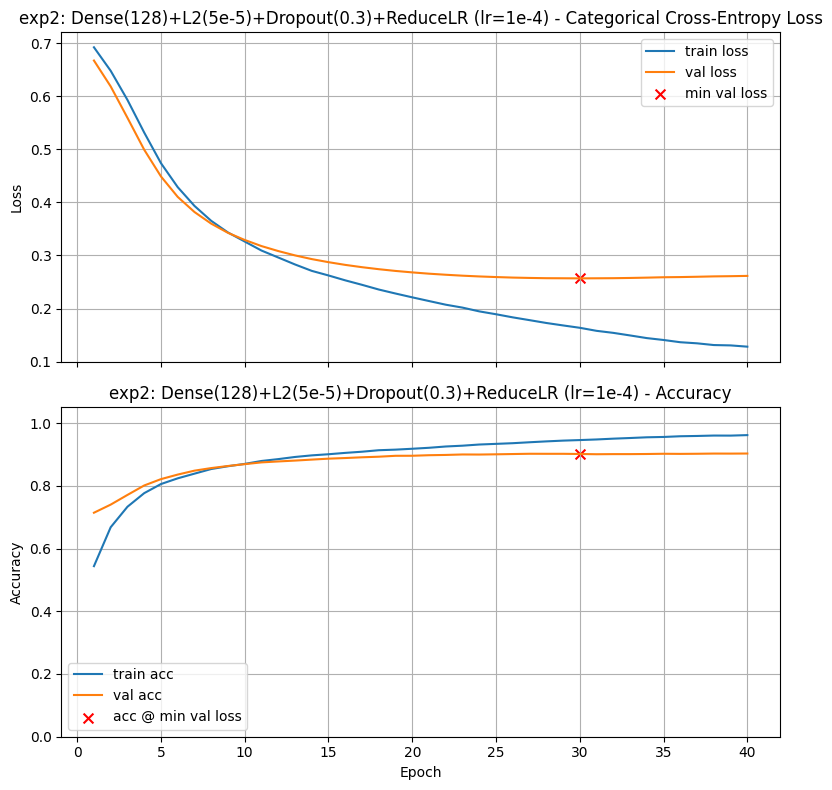


Execution Time: 00:00:40

Final Training Loss:            0.1281
Final Training Accuracy:        0.9617
Final Validation Loss:          0.2614
Final Validation Accuracy:      0.9030
Minimum Validation Loss:        0.2568 (Epoch 30)
Validation Accuracy @ Min Loss: 0.9015

Test Loss: 0.2701
Test Accuracy: 0.8968

Validation-Test Accuracy Gap: 0.004700


In [61]:

# Experiment 2: Larger Dense layer, lighter regularization, with ReduceLROnPlateau

model_exp2 = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim  = training_vocabulary_size,
        output_dim = embedding_dimension,
        weights    = [embedding_matrix],
        mask_zero  = True,
        trainable  = True
    ),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(5e-5)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

train_and_test(model_exp2,
               lr_schedule=1e-4,
               callbacks=[reduce_lr],
               title="exp2: Dense(128)+L2(5e-5)+Dropout(0.3)+ReduceLR (lr=1e-4)")


exp3: Dense(96)+L2(1e-4)+NoDropout+ReduceLR (lr=1e-4)


Epoch 34: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 39: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.


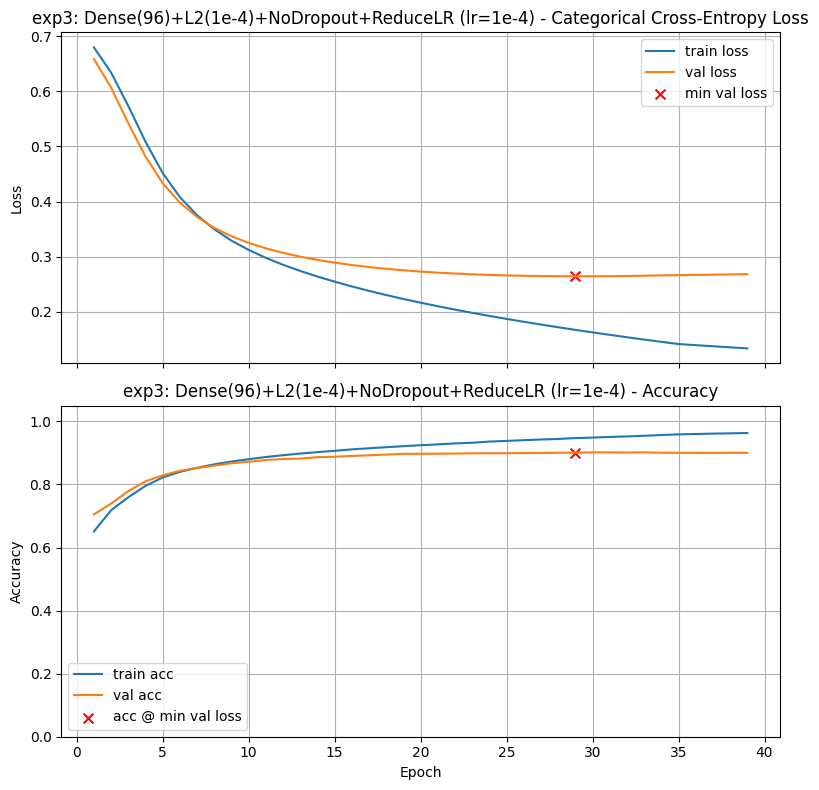


Execution Time: 00:00:39

Final Training Loss:            0.1335
Final Training Accuracy:        0.9630
Final Validation Loss:          0.2682
Final Validation Accuracy:      0.9004
Minimum Validation Loss:        0.2643 (Epoch 29)
Validation Accuracy @ Min Loss: 0.9009

Test Loss: 0.2754
Test Accuracy: 0.8979

Validation-Test Accuracy Gap: 0.002975


In [62]:
#  EXPERIMENT 3: Medium Dense layer, moderate regularization, no dropout

model_exp3 = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim  = training_vocabulary_size,
        output_dim = embedding_dimension,
        weights    = [embedding_matrix],
        mask_zero  = True,
        trainable  = True
    ),
    GlobalAveragePooling1D(),
    Dense(96, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    Dense(1, activation='sigmoid')
])

train_and_test(model_exp3,
               lr_schedule=1e-4,
               callbacks=[reduce_lr],
               title="exp3: Dense(96)+L2(1e-4)+NoDropout+ReduceLR (lr=1e-4)")


In [63]:

print("\n" + "="*70)
print("SUMMARY OF ALL EXPERIMENTS (sorted by validation accuracy)")
print("="*70)
print_results()


best_model = model_baseline_unfrozen

best_title = "model_baseline_unfrozen (lr=1e-3)"
a1a = results[best_title][0]

print(f"\n{'='*70}")
print(f"BEST MODEL FOR PROBLEM 1: {best_title}")
print(f"Validation Accuracy (a1a): {a1a:.4f}")
print(f"{'='*70}\n")


SUMMARY OF ALL EXPERIMENTS (sorted by validation accuracy)
model_baseline_unfrozen (lr=1e-3)       	0.9039	11
exp1: Dense(64)+L2(1e-4)+Dropout(0.5) (lr=1e-4)	0.9031	39
exp2: Dense(128)+L2(5e-5)+Dropout(0.3)+ReduceLR (lr=1e-4)	0.9015	30
exp3: Dense(96)+L2(1e-4)+NoDropout+ReduceLR (lr=1e-4)	0.9009	29
model_baseline (frozen)                 	0.7961	170

BEST MODEL FOR PROBLEM 1: model_baseline_unfrozen (lr=1e-3)
Validation Accuracy (a1a): 0.9039



### Graded Questions

#### Question a1a:

In [85]:
# Set a1a to the validation accuracy for your best model found in this problem

a1a = 0.9039             # Replace 0.0 with your answer

In [86]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1a = {a1a:.4f}')

a1a = 0.9039


#### Question a1b: Describe below your experiments. What worked and what didn't?

#### Your Answer Here: I completed three experiments in addition to the unfrozen and frozen baseline. The first experiment added a dense layer (64) with L2 regularization (1e-4) and a dropout (0.5). This experiment showed that adding a dense layer and regularization helped stablize the model but struggled with generalization/fine tuning. The second experiment increased the size of the dense layer(128) and used ReduceLROnPlateau(5e-5) with a 0.3 dropout. The larger dense layer captured more features but is prone to overfitting. The regularization parameter helped stabilize the model but did not perform better than the baseline. The last experiment used moderate regularization(1e-4) with a moderate dense layer(96) with no dropout. Removing the dropout made the model prone to overfitting and did not perform as well as the unfrozen baseline. The frozen baseline did the worst, proving embeddings are necessary. The unfrozen baseline prevented overfitting due to its simple structure and the high learning rate allowed the model to train efficiently.




## Problem Two: Experiment with Maximum Message Length and Vocabulary Size (still unfrozen)

We might expect that increasing the amount of data by increasing the maximum message length and the vocabulary size would improve results,
but maybe not, or maybe not as much as you would expect. Let's find out!

**ToDo:**

1. Start with your best model from Problem One

2. Consult the information shown in the EDA cells above, and run 2-3 experiments to try to improve this model by increasing either or both of:

    - `max_text_length`, and
    - `training_vocabulary_size`
3. As needed, tweak the learning rate and try it with or without Reduce on Plateau (you can tweak the parametera there as well)
4. Define your best model for use in Problem Three
5. Answer the graded questions

**Note:** `train_and_test` accesses the training and testing files as globals. You can cut and paste copies of the cells which load, preprocess, and build the embeddings for the dataset,
but you'll be **redefining the global names,** just be careful about the order in which you run cells. As an alternative, you can change the parameters in the code in the Prelude, and
just run this problem here.

In [66]:
# Your code here; add as many cells as you need

def reload_data_and_embeddings(vocab_size, max_length):
    global X_train, X_test, y_train, y_test, embedding_matrix, training_vocabulary_size, max_text_length

    training_vocabulary_size = vocab_size
    max_text_length = max_length

    (X_tr, y_tr), (X_te, y_te) = imdb.load_data(num_words=vocab_size)

    X = np.concatenate([X_tr, X_te], axis=0)
    y = np.concatenate([y_tr, y_te], axis=0)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_seed, stratify=y
    )

    X_train = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')
    X_test = pad_sequences(X_test, maxlen=max_length, padding='post', truncating='post')

    word_index = imdb.get_word_index()
    embeddings_index = {}
    glove_path = Path(f"glove.6B/glove.6B.{embedding_dimension}d.txt")
    with glove_path.open(encoding='utf8') as f:
        for line in f:
            word, *vec = line.split()
            embeddings_index[word] = np.asarray(vec, dtype='float32')

    embedding_matrix = np.zeros((vocab_size, embedding_dimension))
    for word, raw_idx in word_index.items():
        idx = raw_idx + 3
        if idx < vocab_size:
            vec = embeddings_index.get(word)
            if vec is not None:
                embedding_matrix[idx] = vec




EXPERIMENT 1: max_text_length=700, vocab=50k

exp1: max_length=700, vocab=50k (lr=1e-3)



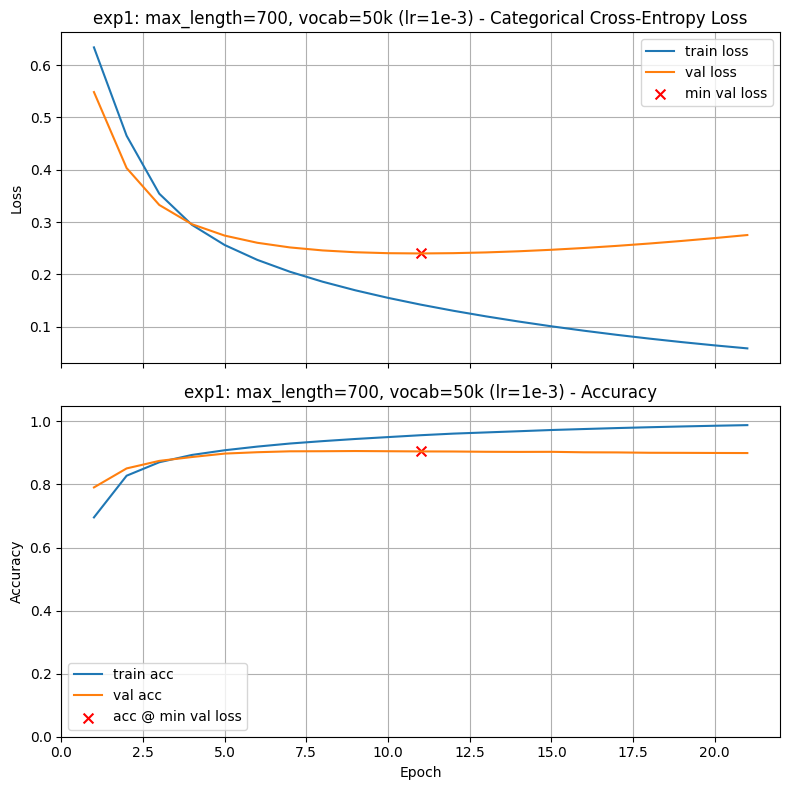


Execution Time: 00:00:26

Final Training Loss:            0.0588
Final Training Accuracy:        0.9882
Final Validation Loss:          0.2753
Final Validation Accuracy:      0.8996
Minimum Validation Loss:        0.2401 (Epoch 11)
Validation Accuracy @ Min Loss: 0.9047

Test Loss: 0.2510
Test Accuracy: 0.9009

Validation-Test Accuracy Gap: 0.003850


In [67]:
# Experiment 1: Increase max_text_length to 700, keep vocab at 50k

print("\n" + "="*70)
print("EXPERIMENT 1: max_text_length=700, vocab=50k")
print("="*70)

reload_data_and_embeddings(vocab_size=50_000, max_length=700)

model_exp1 = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim=training_vocabulary_size,
        output_dim=embedding_dimension,
        weights=[embedding_matrix],
        mask_zero=True,
        trainable=True
    ),
    GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')
])

train_and_test(model_exp1, lr_schedule=1e-3,
               title="exp1: max_length=700, vocab=50k (lr=1e-3)")



EXPERIMENT 2: max_text_length=500, vocab=70k

exp2: max_length=500, vocab=70k (lr=1e-3)



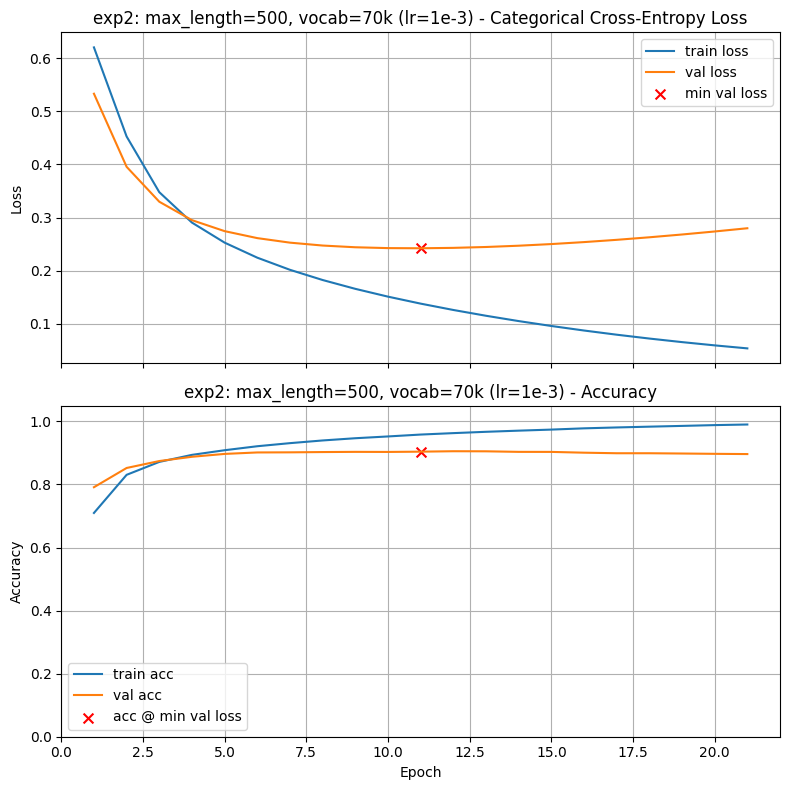


Execution Time: 00:00:22

Final Training Loss:            0.0541
Final Training Accuracy:        0.9901
Final Validation Loss:          0.2801
Final Validation Accuracy:      0.8964
Minimum Validation Loss:        0.2424 (Epoch 11)
Validation Accuracy @ Min Loss: 0.9040

Test Loss: 0.2531
Test Accuracy: 0.9003

Validation-Test Accuracy Gap: 0.003700


In [68]:

# Experiment 2: Increase vocabulary to 70k, keep max_length at 500

print("\n" + "="*70)
print("EXPERIMENT 2: max_text_length=500, vocab=70k")
print("="*70)

reload_data_and_embeddings(vocab_size=70_000, max_length=500)

model_exp2 = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim=training_vocabulary_size,
        output_dim=embedding_dimension,
        weights=[embedding_matrix],
        mask_zero=True,
        trainable=True
    ),
    GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')
])

train_and_test(model_exp2, lr_schedule=1e-3,
               title="exp2: max_length=500, vocab=70k (lr=1e-3)")



EXPERIMENT 3: max_text_length=700, vocab=70k

exp3: max_length=700, vocab=70k (lr=1e-3)



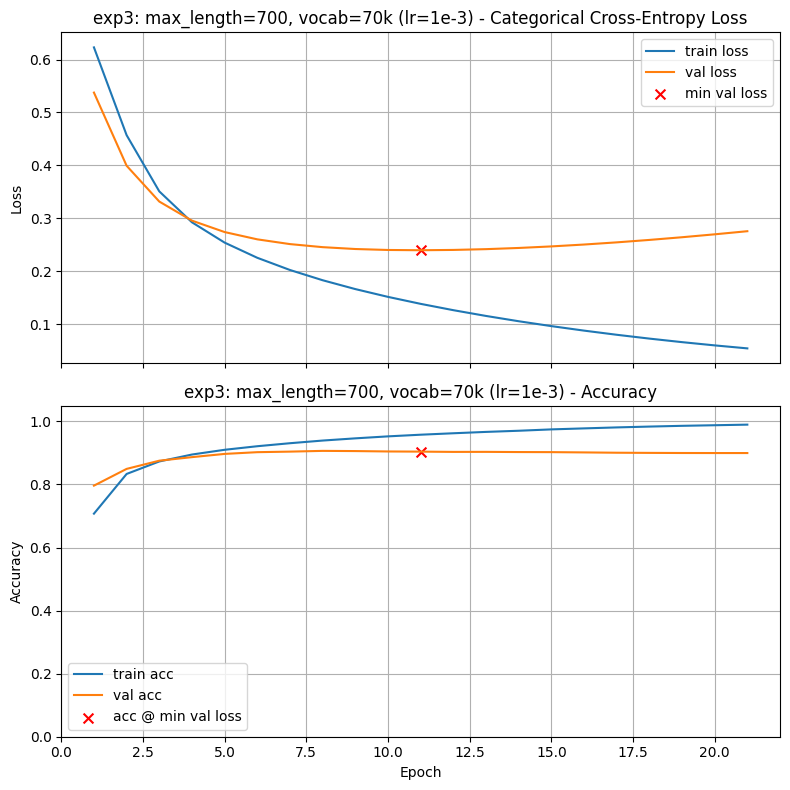


Execution Time: 00:00:26

Final Training Loss:            0.0545
Final Training Accuracy:        0.9897
Final Validation Loss:          0.2758
Final Validation Accuracy:      0.8996
Minimum Validation Loss:        0.2398 (Epoch 11)
Validation Accuracy @ Min Loss: 0.9041

Test Loss: 0.2510
Test Accuracy: 0.9033

Validation-Test Accuracy Gap: 0.000825


In [69]:
# Experiment 3: Increase both max_length to 700 AND vocab to 70k

print("\n" + "="*70)
print("EXPERIMENT 3: max_text_length=700, vocab=70k")
print("="*70)

reload_data_and_embeddings(vocab_size=70_000, max_length=700)

model_exp3 = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim=training_vocabulary_size,
        output_dim=embedding_dimension,
        weights=[embedding_matrix],
        mask_zero=True,
        trainable=True
    ),
    GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')
])

train_and_test(model_exp3, lr_schedule=1e-3,
               title="exp3: max_length=700, vocab=70k (lr=1e-3)")


In [70]:
print("\n" + "="*70)
print("SUMMARY OF ALL EXPERIMENTS (Problem 2)")
print("="*70)
print_results()


SUMMARY OF ALL EXPERIMENTS (Problem 2)
exp1: max_length=700, vocab=50k (lr=1e-3)	0.9047	11
exp3: max_length=700, vocab=70k (lr=1e-3)	0.9041	11
exp2: max_length=500, vocab=70k (lr=1e-3)	0.9040	11
model_baseline_unfrozen (lr=1e-3)       	0.9039	11
exp1: Dense(64)+L2(1e-4)+Dropout(0.5) (lr=1e-4)	0.9031	39
exp2: Dense(128)+L2(5e-5)+Dropout(0.3)+ReduceLR (lr=1e-4)	0.9015	30
exp3: Dense(96)+L2(1e-4)+NoDropout+ReduceLR (lr=1e-4)	0.9009	29
model_baseline (frozen)                 	0.7961	170


In [71]:
best_model_p2 = model_exp1
best_title_p2 = "exp1: max_length=700, vocab=50k (lr=1e-3)"
a2a = results[best_title_p2][0]

print(f"\n{'='*70}")
print(f"BEST MODEL FOR PROBLEM 2: {best_title_p2}")
print(f"Validation Accuracy (a2a): {a2a:.4f}")
print(f"{'='*70}\n")


BEST MODEL FOR PROBLEM 2: exp1: max_length=700, vocab=50k (lr=1e-3)
Validation Accuracy (a2a): 0.9047



### Graded Questions

In [87]:
# Set a2a to the validation accuracy for your best model found in this problem

a2a = 0.9047             # Replace 0.0 with your answer

In [88]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2a = {a2a:.4f}')

a2a = 0.9047


#### Question a2b: Describe below your experiments. What effect did your changes to the dataset have? Did it help as you as you expected?   

#### Your Answer Here: In this problem, the best model was experiment one with an accuracy of 0.9047. This experiment used a max length of 700 and a vocab size of 50k. The second best performer was experiment 3 which also had a max length of 700 but a vocab size of 70k. The second experiment, the use of max length of 500 and a vocab of 70k performed the worse out of all three experiments. This indicates that max length contributes more to model performance than increasing vocab size since the experiments with higher max lengths outperformed the experiment with a smaller max length. I did expect this result as increasing vocab size puts the model at risk to fitting to noise while increasing max length allows for the model to gain context and improve accuracy.

## Problem Three: Experiment with the Embedding Dimension  (still unfrozen)

We might expect that increasing the embedding dimension would improve your results!
Again, maybe not, or maybe not as much as you would expect. Let's find out!

**ToDo:**

1. Start with your best model from Problem Two (which used an embedding dimension of 100)
2. Try an embedding dimension of 300 to see the effect. (Optional: Try 50 and 200 as well.)
3. As necessary weak the learning rate and try it with or without Reduce on Plateau (you can tweak the parameters there as well)
4. Answer the graded questions

In [74]:
# Your code here; add as many cells as you need

print("Loading GloVe embeddings for all dimensions...")
glove_embeddings = {}
for dim in [50, 100, 200, 300]:
    glove_path = Path(f"glove.6B/glove.6B.{dim}d.txt")
    embeddings_index = {}
    with glove_path.open(encoding='utf8') as f:
        for line in f:
            word, *vec = line.split()
            embeddings_index[word] = np.asarray(vec, dtype='float32')
    glove_embeddings[dim] = embeddings_index
    print(f"  Loaded {dim}d: {len(embeddings_index):,} words")

def reload_data_and_embeddings_dim(vocab_size, max_length, emb_dim):
    global X_train, X_test, y_train, y_test, embedding_matrix, training_vocabulary_size, max_text_length, embedding_dimension

    training_vocabulary_size = vocab_size
    max_text_length = max_length
    embedding_dimension = emb_dim

    (X_tr, y_tr), (X_te, y_te) = imdb.load_data(num_words=vocab_size)

    X = np.concatenate([X_tr, X_te], axis=0)
    y = np.concatenate([y_tr, y_te], axis=0)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_seed, stratify=y
    )

    X_train = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')
    X_test = pad_sequences(X_test, maxlen=max_length, padding='post', truncating='post')

    word_index = imdb.get_word_index()
    embeddings_index = glove_embeddings[emb_dim]

    embedding_matrix = np.zeros((vocab_size, emb_dim))
    for word, raw_idx in word_index.items():
        idx = raw_idx + 3
        if idx < vocab_size:
            vec = embeddings_index.get(word)
            if vec is not None:
                embedding_matrix[idx] = vec

vocab_size_p3 = 70_000
max_length_p3 = 700


Loading GloVe embeddings for all dimensions...
  Loaded 50d: 400,000 words
  Loaded 100d: 400,000 words
  Loaded 200d: 400,000 words
  Loaded 300d: 400,000 words



BASELINE (Problem 2): embedding_dimension=100

baseline: dim=100 (lr=1e-3)



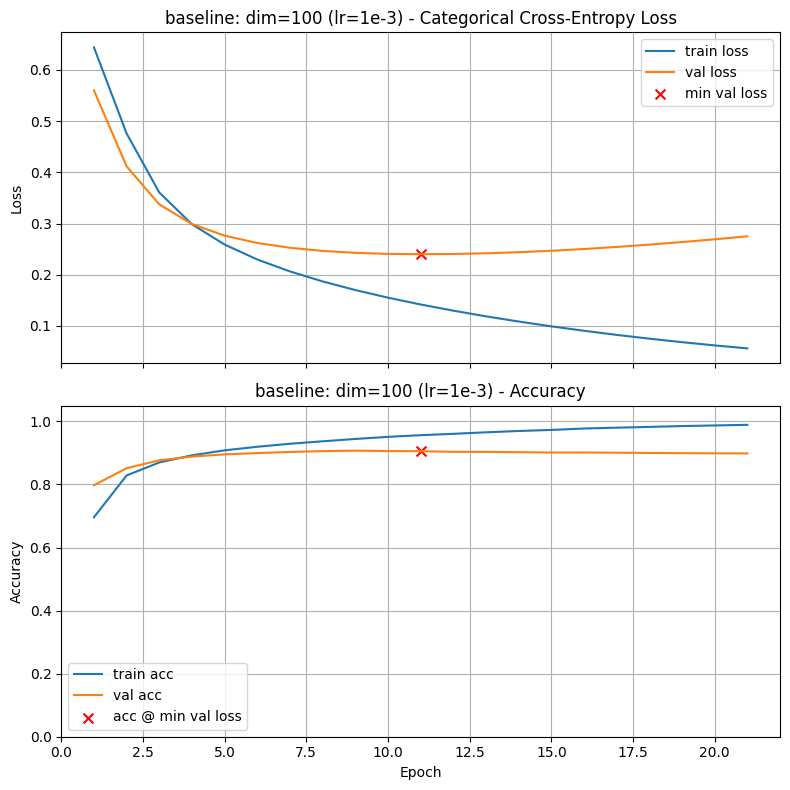


Execution Time: 00:00:27

Final Training Loss:            0.0562
Final Training Accuracy:        0.9891
Final Validation Loss:          0.2750
Final Validation Accuracy:      0.8984
Minimum Validation Loss:        0.2401 (Epoch 11)
Validation Accuracy @ Min Loss: 0.9054

Test Loss: 0.2507
Test Accuracy: 0.9020

Validation-Test Accuracy Gap: 0.003375


In [75]:
# Baseline: embedding_dimension = 100

print("\n" + "="*70)
print("BASELINE (Problem 2): embedding_dimension=100")
print("="*70)

reload_data_and_embeddings_dim(vocab_size=vocab_size_p3, max_length=max_length_p3, emb_dim=100)

model_baseline_dim100 = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim=training_vocabulary_size,
        output_dim=embedding_dimension,
        weights=[embedding_matrix],
        mask_zero=True,
        trainable=True
    ),
    GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')
])

train_and_test(model_baseline_dim100, lr_schedule=1e-3,
               title="baseline: dim=100 (lr=1e-3)")



EXPERIMENT 1: embedding_dimension=50

exp1: dim=50 (lr=1e-3)



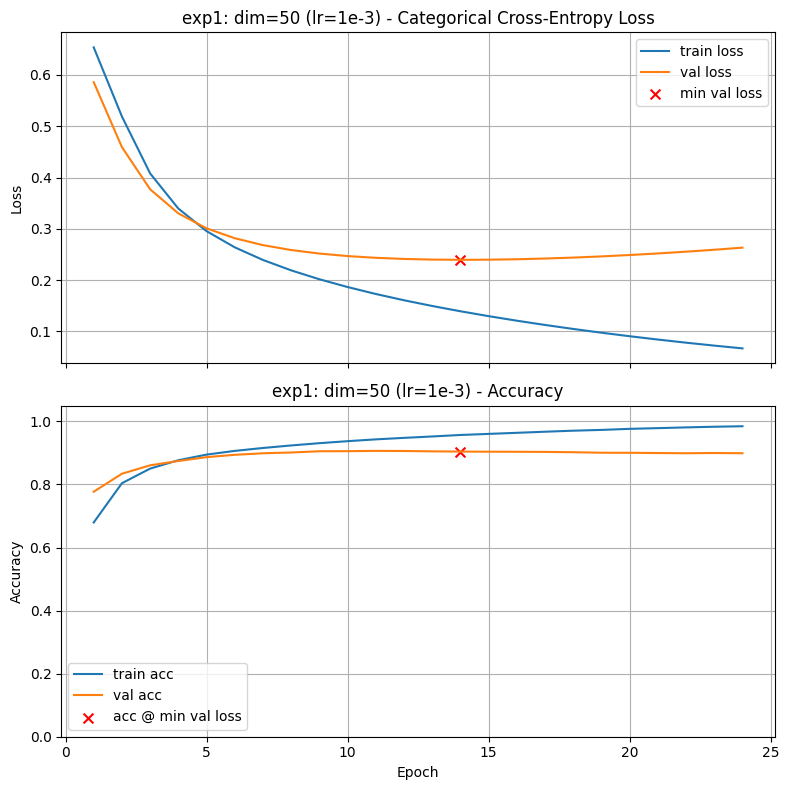


Execution Time: 00:00:22

Final Training Loss:            0.0670
Final Training Accuracy:        0.9846
Final Validation Loss:          0.2633
Final Validation Accuracy:      0.8990
Minimum Validation Loss:        0.2396 (Epoch 14)
Validation Accuracy @ Min Loss: 0.9043

Test Loss: 0.2504
Test Accuracy: 0.9013

Validation-Test Accuracy Gap: 0.002950


In [76]:
# Experiment 1: embedding_dimension = 50

print("\n" + "="*70)
print("EXPERIMENT 1: embedding_dimension=50")
print("="*70)

reload_data_and_embeddings_dim(vocab_size=vocab_size_p3, max_length=max_length_p3, emb_dim=50)

model_exp1_dim50 = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim=training_vocabulary_size,
        output_dim=embedding_dimension,
        weights=[embedding_matrix],
        mask_zero=True,
        trainable=True
    ),
    GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')
])

train_and_test(model_exp1_dim50, lr_schedule=1e-3,
               title="exp1: dim=50 (lr=1e-3)")




EXPERIMENT 2: embedding_dimension=200

exp2: dim=200 (lr=1e-4 + ReduceLR)


Epoch 76: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.


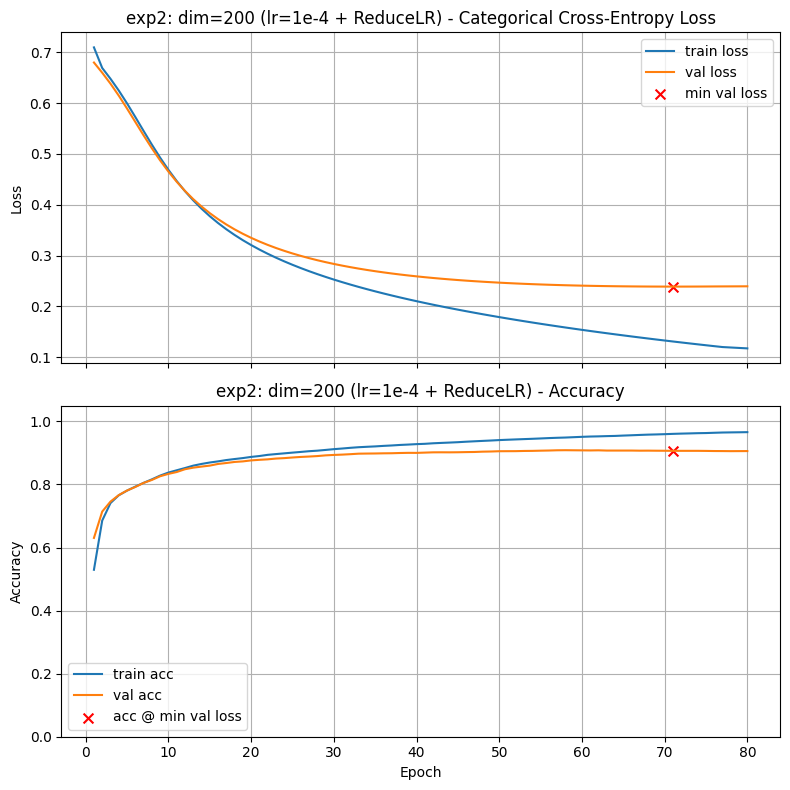


Execution Time: 00:02:52

Final Training Loss:            0.1174
Final Training Accuracy:        0.9659
Final Validation Loss:          0.2396
Final Validation Accuracy:      0.9059
Minimum Validation Loss:        0.2390 (Epoch 71)
Validation Accuracy @ Min Loss: 0.9066

Test Loss: 0.2507
Test Accuracy: 0.9019

Validation-Test Accuracy Gap: 0.004725


In [77]:
# Experiment 2: embedding_dimension = 200

print("\n" + "="*70)
print("EXPERIMENT 2: embedding_dimension=200")
print("="*70)

reload_data_and_embeddings_dim(vocab_size=vocab_size_p3, max_length=max_length_p3, emb_dim=200)

model_exp2_dim200 = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim=training_vocabulary_size,
        output_dim=embedding_dimension,
        weights=[embedding_matrix],
        mask_zero=True,
        trainable=True
    ),
    GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')
])

train_and_test(model_exp2_dim200, lr_schedule=1e-4,
               callbacks=[reduce_lr],
               title="exp2: dim=200 (lr=1e-4 + ReduceLR)")


EXPERIMENT 3: embedding_dimension=300

exp3: dim=300 (lr=1e-4 + ReduceLR)


Epoch 61: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 66: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.


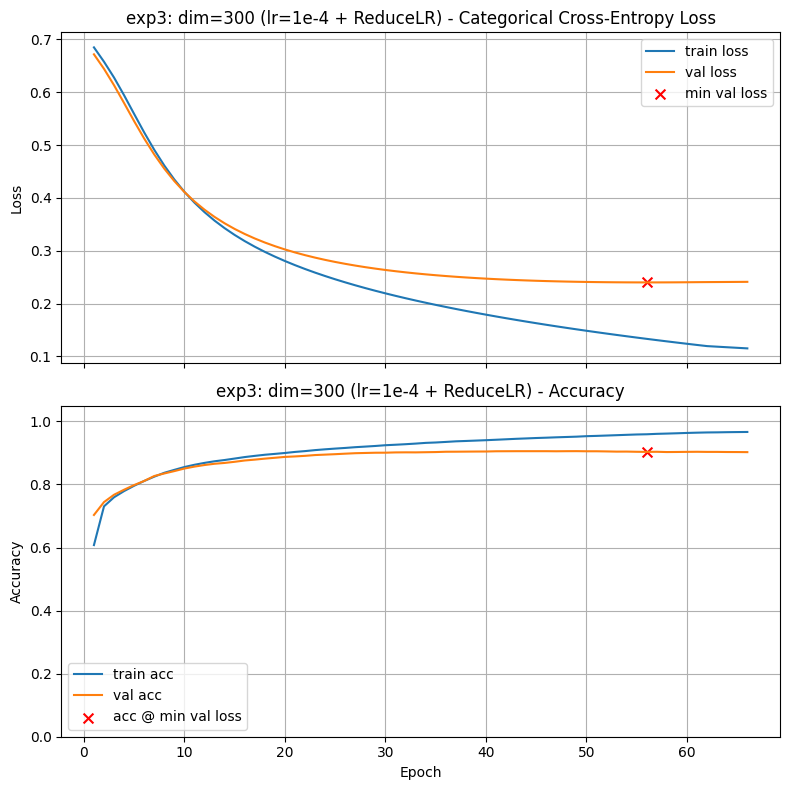


Execution Time: 00:02:42

Final Training Loss:            0.1151
Final Training Accuracy:        0.9665
Final Validation Loss:          0.2411
Final Validation Accuracy:      0.9025
Minimum Validation Loss:        0.2400 (Epoch 56)
Validation Accuracy @ Min Loss: 0.9032

Test Loss: 0.2508
Test Accuracy: 0.9010

Validation-Test Accuracy Gap: 0.002250


In [78]:
# Experiment 3: embedding_dimension = 300

print("\n" + "="*70)
print("EXPERIMENT 3: embedding_dimension=300")
print("="*70)

reload_data_and_embeddings_dim(vocab_size=vocab_size_p3, max_length=max_length_p3, emb_dim=300)

model_exp3_dim300 = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim=training_vocabulary_size,
        output_dim=embedding_dimension,
        weights=[embedding_matrix],
        mask_zero=True,
        trainable=True
    ),
    GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')
])

train_and_test(model_exp3_dim300, lr_schedule=1e-4,
               callbacks=[reduce_lr],
               title="exp3: dim=300 (lr=1e-4 + ReduceLR)")

In [79]:
print("\n" + "="*70)
print("SUMMARY OF ALL EXPERIMENTS (Problem 3)")
print("="*70)
print_results()



SUMMARY OF ALL EXPERIMENTS (Problem 3)
exp2: dim=200 (lr=1e-4 + ReduceLR)      	0.9066	71
baseline: dim=100 (lr=1e-3)             	0.9054	11
exp1: max_length=700, vocab=50k (lr=1e-3)	0.9047	11
exp1: dim=50 (lr=1e-3)                  	0.9043	14
exp3: max_length=700, vocab=70k (lr=1e-3)	0.9041	11
exp2: max_length=500, vocab=70k (lr=1e-3)	0.9040	11
model_baseline_unfrozen (lr=1e-3)       	0.9039	11
exp3: dim=300 (lr=1e-4 + ReduceLR)      	0.9032	56
exp1: Dense(64)+L2(1e-4)+Dropout(0.5) (lr=1e-4)	0.9031	39
exp2: Dense(128)+L2(5e-5)+Dropout(0.3)+ReduceLR (lr=1e-4)	0.9015	30
exp3: Dense(96)+L2(1e-4)+NoDropout+ReduceLR (lr=1e-4)	0.9009	29
model_baseline (frozen)                 	0.7961	170


In [89]:
best_model_p3 = model_exp2_dim200
best_title_p3 = "exp2: dim=200 (lr=1e-4 + ReduceLR)"
a3a = results[best_title_p3][0]

print(f"\n{'='*70}")
print(f"BEST MODEL FOR PROBLEM 3: {best_title_p3}")
print(f"Validation Accuracy (a3a): {a3a:.4f}")
print(f"{'='*70}\n")


BEST MODEL FOR PROBLEM 3: exp2: dim=200 (lr=1e-4 + ReduceLR)
Validation Accuracy (a3a): 0.9066



### Graded Questions

In [90]:
# Set a3a to the validation accuracy for your best model found in this problem

a3a = 0.9066             # Replace 0.0 with your answer

In [91]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3a = {a3a:.4f}')

a3a = 0.9066


#### Question a3b: Describe below your experiments. What effect did increasing the dimension from 100 to 300 have? Did it help as you as you expected?  

#### Your Answer Here: In the final problem, I experimented with embedding dimensions of 50, 100, 200, and 300. It was determined that increasing from 100 to 200 did increase the model's performance slightly but increasing from 200 to 300 decreased the model's accuracy. This indicates that a moderate embedding size is best for the model's accuracy and efficiency given this dataset. I did expect this as I believed a dimension too small would not capture the data adquedatly where a large dimension may be prone to overfit.

In [83]:
print_results()

exp2: dim=200 (lr=1e-4 + ReduceLR)      	0.9066	71
baseline: dim=100 (lr=1e-3)             	0.9054	11
exp1: max_length=700, vocab=50k (lr=1e-3)	0.9047	11
exp1: dim=50 (lr=1e-3)                  	0.9043	14
exp3: max_length=700, vocab=70k (lr=1e-3)	0.9041	11
exp2: max_length=500, vocab=70k (lr=1e-3)	0.9040	11
model_baseline_unfrozen (lr=1e-3)       	0.9039	11
exp3: dim=300 (lr=1e-4 + ReduceLR)      	0.9032	56
exp1: Dense(64)+L2(1e-4)+Dropout(0.5) (lr=1e-4)	0.9031	39
exp2: Dense(128)+L2(5e-5)+Dropout(0.3)+ReduceLR (lr=1e-4)	0.9015	30
exp3: Dense(96)+L2(1e-4)+NoDropout+ReduceLR (lr=1e-4)	0.9009	29
model_baseline (frozen)                 	0.7961	170


In [84]:
# This will have recorded details of all your experiments

parameter_settings

{'model_baseline (frozen)': [{'title': 'model_baseline (frozen)',
   'timestamp': '2025-10-16T01:09:43',
   'epochs': 200,
   'optimizer': 'Adam',
   'lr_schedule': 0.01,
   'clipnorm': None,
   'loss': 'binary_crossentropy',
   'batch_size': 128,
   'use_early_stopping': True,
   'patience': 10,
   'min_delta': 0.0001,
   'callbacks': [],
   'Final Training Loss': 0.44107717275619507,
   'Final Training Accuracy': 0.7985000014305115,
   'Final Val Loss': 0.4321281909942627,
   'Final Val Accuracy': 0.7961249947547913,
   'Min Val Loss': 0.4321281909942627,
   'Min Val Loss Epoch': np.int64(169),
   'Val Acc @ Min Loss': 0.7961249947547913,
   'Test Loss': 0.4330720603466034,
   'Test Acc': 0.8076000213623047,
   'Val-Test Accuracy Gap:': 0.011475026607513428}],
 'model_baseline_unfrozen (lr=1e-3)': [{'title': 'model_baseline_unfrozen (lr=1e-3)',
   'timestamp': '2025-10-16T01:10:05',
   'epochs': 200,
   'optimizer': 'Adam',
   'lr_schedule': 0.001,
   'clipnorm': None,
   'loss': 'bi